<a href="https://colab.research.google.com/github/nirajlondhe8/aiml/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from google.colab import files

# Upload the dataset
uploaded = files.upload()  # Upload your CSV file from local disk

# Assuming the uploaded file is in CSV format
for filename in uploaded.keys():
    print(f'Uploaded file: {filename}')
    data = pd.read_csv(filename)  # Read the uploaded file



Saving Quality of Service 5G.csv to Quality of Service 5G (1).csv
Uploaded file: Quality of Service 5G (1).csv


<ipython-input-6-596a599561e1>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Application_Type'] = label_encoder.fit_transform(features['Application_Type'])
<ipython-input-6-596a599561e1>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[['Signal_Strength', 'Latency', 'Required_Bandwidth', 'Allocated_Bandwidth']] = scaler.fit_transform(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. Whe

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - loss: 0.5898 - val_loss: 0.1324
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0963 - val_loss: 0.0483
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0600 - val_loss: 0.0103
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0304 - val_loss: 0.0092
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0215 - val_loss: 0.0102
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0261 - val_loss: 0.0087
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0223 - val_loss: 0.0077
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0207 - val_loss: 0.0077
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0171 - val_loss: 0.0088
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0167 - val_loss: 0.0072
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0082
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0074
Train Loss: 0.007983522489666939, Test Loss: 0.007238966412842

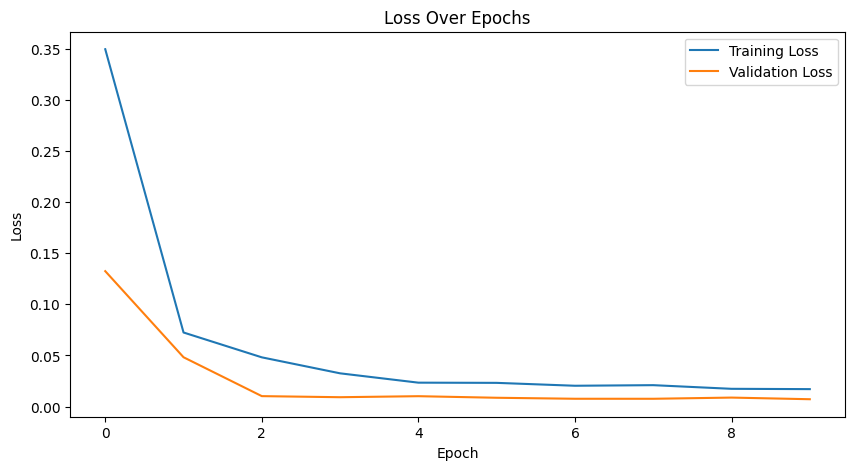

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step


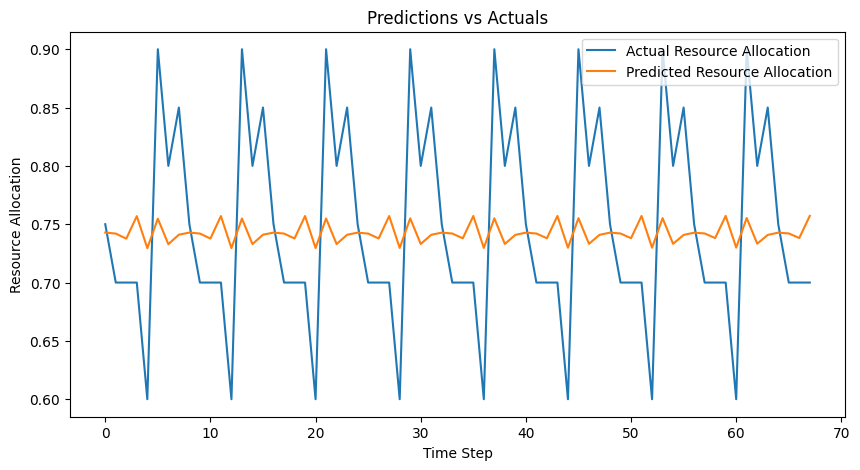

In [6]:
# Clean and preprocess the data

# Convert Resource_Allocation to numeric (if it's a string, remove the percentage sign)
def clean_resource_allocation(value):
    if isinstance(value, str):
        return float(value.rstrip('%')) / 100.0  # Remove the '%' and convert to float
    return value  # If it's already numeric, return as is

data['Resource_Allocation'] = data['Resource_Allocation'].apply(clean_resource_allocation)

# Now the rest of the processing continues as before
# Select features: Timestamp is not used directly, User_ID is irrelevant, so we will use other columns
features = data[['Signal_Strength', 'Latency', 'Required_Bandwidth', 'Allocated_Bandwidth', 'Application_Type']]

# Use Label Encoding for categorical feature 'Application_Type'
label_encoder = LabelEncoder()
features['Application_Type'] = label_encoder.fit_transform(features['Application_Type'])

# Select the target: 'Resource_Allocation'
target = data['Resource_Allocation'].values

# Normalize the features (except 'Application_Type')
scaler = MinMaxScaler(feature_range=(0, 1))
features[['Signal_Strength', 'Latency', 'Required_Bandwidth', 'Allocated_Bandwidth']] = scaler.fit_transform(
    features[['Signal_Strength', 'Latency', 'Required_Bandwidth', 'Allocated_Bandwidth']])

# Convert to numpy arrays
X = features.values
y = target

# Create a dataset with a window of 60 time steps (using past data points)
def create_dataset(X, y, time_step=60):
    Xs, ys = [], []
    for i in range(time_step, len(X)):
        Xs.append(X[i-time_step:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

time_step = 60
X, y = create_dataset(X, y, time_step)

# Split the dataset into training and testing sets (80% train, 20% test)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape the input data for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer for regression

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
train_loss = model.evaluate(X_train, y_train)
test_loss = model.evaluate(X_test, y_test)
print(f'Train Loss: {train_loss}, Test Loss: {test_loss}')

# Visualize the training loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Make predictions
predictions = model.predict(X_test)

# Visualize the predictions vs actuals
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual Resource Allocation')
plt.plot(predictions, label='Predicted Resource Allocation')
plt.title('Predictions vs Actuals')
plt.xlabel('Time Step')
plt.ylabel('Resource Allocation')
plt.legend()
plt.show()


In [7]:
# Summary Statistics
summary = data.describe()

# Count of unique values for categorical columns
unique_counts = data.select_dtypes(include=['object']).nunique()

# Display the summary statistics and unique counts
print("Summary Statistics:")
print(summary)

print("\nUnique Counts of Categorical Variables:")
print(unique_counts)

Summary Statistics:
                 Timestamp  Signal_Strength     Latency  Required_Bandwidth  \
count                  400       400.000000  400.000000          400.000000   
mean   2023-09-03 10:03:00       -80.495000   33.825000            3.135512   
min    2023-09-03 10:00:00      -123.000000    0.000000            0.000000   
25%    2023-09-03 10:01:00       -98.000000   21.750000            0.417500   
50%    2023-09-03 10:03:00       -83.000000   31.000000            1.200000   
75%    2023-09-03 10:05:00       -64.000000   45.000000            4.100000   
max    2023-09-03 10:06:00       -40.000000  110.000000           14.500000   
std                    NaN        20.701119   21.122139            3.984097   

       Allocated_Bandwidth  Resource_Allocation  
count           400.000000           400.000000  
mean              3.502380             0.747125  
min               0.000000             0.500000  
25%               0.417500             0.700000  
50%               